##Amruta Mahendra Parulekar 20D070009
##Keshav Singhal 20D070047
##Sameep Chattopadhyay 20d070067

In [ ]:
%matplotlib inline

In [ ]:
# !pip install pydub torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w[2:] not in excludes] #Edited line to get correct training set, Keshav


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set_init = SubsetSC("training")
test_set_init = SubsetSC("testing")



  0%|          | 0.00/2.26G [00:00<?, ?B/s]

In [ ]:
len(train_set_init)

105829

In [ ]:
import urllib.request as req
data_test = req.urlopen(r"https://www.cse.iitb.ac.in/~pjyothi/cs753/test_list.txt")
data_train = req.urlopen(r"https://www.cse.iitb.ac.in/~pjyothi/cs753/train_list.txt")
n_test=[]
n_train=[]
for num in data_test:
  n_test.append(int(num))
for num in data_train:
  n_train.append(int(num))

In [ ]:
train_set=list([train_set_init[n] for n in n_train])
test_set=list([test_set_init[n] for n in n_test])

In [ ]:
import pickle
with open('/content/blind_test.pkl', 'rb') as f:
  blind = pickle.load(f)
blind_set = [test_set_init[i] for i in blind]
test_set = blind_set

In [ ]:
# print(test_set[i][2])
print(len(train_set))






12000


In [ ]:
waveform, sample_rate, label, speaker_id, utterance_number = train_set[-1]
print(sample_rate)
print(label)
print(utterance_number)
print(speaker_id)

16000
tree
0
1afd49bf


In [ ]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
len(labels)

29

In [ ]:
test_set_temp=[]
for i in range(len(test_set)):
  if test_set[i][2] in labels:
    test_set_temp.append(test_set[i])
test_set=list(test_set_temp)

In [ ]:
id = sorted(list(set(datapoint[4] for datapoint in train_set)))
len(id)

19

In [ ]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

In [ ]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "bed"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

bed --> tensor(1) --> bed


Shape of waveform: torch.Size([1, 15019])
Sample rate of waveform: 16000


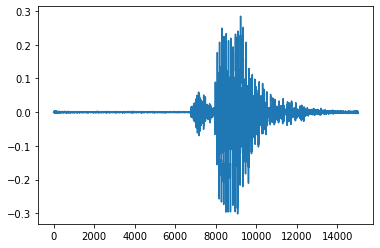

In [ ]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

torch.Size([1, 12, 76])


/usr/local/lib/python3.9/dist-packages/torchaudio/functional/functional.py:571: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


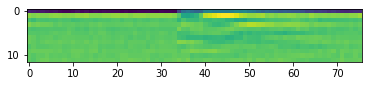

In [ ]:
mfcc = torchaudio.transforms.MFCC(n_mfcc=12, log_mels=True)(waveform)
plt.figure()
plt.imshow(mfcc[0].detach().numpy())
print(mfcc.shape)

In [ ]:
classes = sorted(os.listdir('./SpeechCommands/speech_commands_v0.02'))
classes.remove("LICENSE")
classes.remove("README.md")
classes.remove("_background_noise_")
classes.remove("testing_list.txt")
classes.remove("validation_list.txt")
classes.remove('.DS_Store')

In [ ]:
class SpeechDataset(torch.utils.data.Dataset):

  def __init__(self, classes, file_list):

    self.classes = labels

    # create a map from class name to integer
    self.class_to_int = dict(zip(classes, range(len(classes))))

    # store the file names
    self.samples = file_list

    # store our MFCC transform
    self.mfcc_transform = torchaudio.transforms.MFCC(n_mfcc=12, log_mels=True)

  def __len__(self):
    return len(self.samples)

  def __getitem__(self,i):
    with torch.no_grad():
      # load a normalized waveform
      #waveform,_ = torchaudio.load(self.samples[i], normalize=True)
      waveform  = self.samples[i][0]
      labels  = self.samples[i][2]

      # if the waveform is too short (less than 1 second) we pad it with zeroes
      if waveform.shape[1] < 16000:
        waveform = F.pad(input=waveform, pad=(0, 16000 - waveform.shape[1]), mode='constant', value=0)

      # then, we apply the transform
      mfcc = self.mfcc_transform(waveform).squeeze(0).transpose(0,1)



    # return the mfcc coefficient with the sample label
    return mfcc, self.class_to_int[labels]

In [ ]:
if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

batch_size = 256
train_dataset = SpeechDataset(classes,train_set)
train_dl = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)
test_dataset = SpeechDataset(classes,test_set)
test_dl = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)

In [ ]:
# class SpeechRNN(torch.nn.Module):

#   def __init__(self):
#     super(SpeechRNN, self).__init__()

#     self.lstm = torch.nn.RNN(##YOUR CODE HERE

#     self.out_layer = ##YOUR CODE HERE

#     self.softmax = torch.nn.LogSoftmax(dim=1)

#   def forward(self, x):

#     out, _ = self.lstm(x)

#     x = self.out_layer(out[:,-1,:])

#     return self.softmax(x)

#LSTM

class SpeechLSTM(torch.nn.Module):

  def __init__(self):
    super(SpeechLSTM, self).__init__()

    self.lstm_size = 400
    self.num_layers = 3
    self.input_size = 12

    self.lstm = torch.nn.LSTM(
        input_size=self.input_size, num_layers=self.num_layers, hidden_size=self.lstm_size, batch_first=True, dropout=0.2
    )

    self.out_layer = torch.nn.Linear(self.lstm_size, 35)

  def forward(self, x, prev_state=None):

    if prev_state is None:
      prev_state = self.init_state(x.size(0))

    prev_state = tuple(h.to(x.device) for h in prev_state)
    out, state = self.lstm(x, prev_state)

    x = self.out_layer(out[:, -1, :])

    return F.log_softmax(x, dim=1), state

  def init_state(self, batch_size):
    return (torch.zeros(self.num_layers, batch_size, self.lstm_size), torch.zeros(self.num_layers, batch_size, self.lstm_size))


In [ ]:
model = SpeechLSTM()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # reduce the learning after 20 epochs by a factor of 10

In [ ]:
# ##RE-RUN THIS CODE TO GET A "NEW" NETWORK

# LEARNING_RATE = 0.001

# ## Create an instance of our network
# net = LSTM(labels)

# ## Move it to the GPU
# net = net.to(device)

# # Negative log likelihood loss
# criterion = torch.nn.NLLLoss()

# # Adam optimizer
# optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [ ]:
# basic random seed
import os
import random
import numpy as np
DEFAULT_RANDOM_SEED = 2021
def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
# tensorflow random seed
import tensorflow as tf
def seedTF(seed=DEFAULT_RANDOM_SEED):
    tf.random.set_seed(seed)
# torch random seed
import torch
def seedTorch(seed=DEFAULT_RANDOM_SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
# basic + tensorflow + torch
def seedEverything(seed=DEFAULT_RANDOM_SEED):
    seedBasic(seed)
    seedTF(seed)
    seedTorch(seed)
    seedEverything(1004)

In [ ]:
from tqdm import tqdm_notebook


In [ ]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_dl):

        data = data.to(device)
        target = target.to(device)
        # print(data.shape)

        output = model(data)
        # print(output.argmax(dim=-1))
        # print(target)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output[0], target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_dl.dataset)} ({100. * batch_idx / len(train_dl):.2f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

In [ ]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()

def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)

def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_dl:
        print(data.size(), target.size())
        data = data.to(device)
        target = target.to(device)

        output = model(data)

        pred = get_likely_index(output[0])
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_dl.dataset)} ({100. * correct / len(test_dl.dataset):.2f}%)\n{100. * correct / len(test_dl.dataset):.2f}")

In [ ]:
log_interval = 20
n_epoch = 20

pbar_update = 1 / (len(train_dl) + len(test_dl))
losses = []

with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        # test(model, epoch)
        scheduler.step()

  0%|          | 0.03508771929824561/20 [00:00<04:15, 12.79s/it] 

Train Epoch: 1 [0/12000 (0.00%)]	Loss: 3.559900


  2%|▏         | 0.38596491228070173/20 [00:06<05:05, 15.60s/it]

Train Epoch: 1 [5120/12000 (42.55%)]	Loss: 3.041776


  4%|▎         | 0.7368421052631586/20 [00:12<05:00, 15.61s/it]

Train Epoch: 1 [10240/12000 (85.11%)]	Loss: 2.654071


  4%|▍         | 0.8421052631578958/20 [00:14<06:04, 19.01s/it]

Train Epoch: 2 [0/12000 (0.00%)]	Loss: 2.585178


  6%|▌         | 1.210526315789476/20 [00:20<04:48, 15.38s/it]

Train Epoch: 2 [5120/12000 (42.55%)]	Loss: 2.332406


  8%|▊         | 1.5614035087719331/20 [00:26<04:43, 15.37s/it]

Train Epoch: 2 [10240/12000 (85.11%)]	Loss: 2.211079


  8%|▊         | 1.6842105263157932/20 [00:28<05:24, 17.72s/it]

Train Epoch: 3 [0/12000 (0.00%)]	Loss: 2.126632


 10%|█         | 2.03508771929825/20 [00:34<04:28, 14.94s/it]  

Train Epoch: 3 [5120/12000 (42.55%)]	Loss: 2.001025


 12%|█▏        | 2.3859649122807074/20 [00:39<04:41, 15.98s/it]

Train Epoch: 3 [10240/12000 (85.11%)]	Loss: 1.472986


 12%|█▏        | 2.4912280701754446/20 [00:41<05:48, 19.90s/it]

Train Epoch: 4 [0/12000 (0.00%)]	Loss: 1.279872


 14%|█▍        | 2.8596491228070247/20 [00:47<04:13, 14.77s/it]

Train Epoch: 4 [5120/12000 (42.55%)]	Loss: 1.221580


 16%|█▌        | 3.210526315789482/20 [00:52<04:42, 16.81s/it]

Train Epoch: 4 [10240/12000 (85.11%)]	Loss: 0.964012


 17%|█▋        | 3.333333333333342/20 [00:55<04:20, 15.64s/it]

Train Epoch: 5 [0/12000 (0.00%)]	Loss: 1.043954


 18%|█▊        | 3.684210526315799/20 [01:00<04:00, 14.72s/it] 

Train Epoch: 5 [5120/12000 (42.55%)]	Loss: 0.971095


 20%|██        | 4.017543859649133/20 [01:06<05:23, 20.25s/it]

Train Epoch: 5 [10240/12000 (85.11%)]	Loss: 0.790459


 21%|██        | 4.157894736842112/20 [01:08<04:04, 15.41s/it]

Train Epoch: 6 [0/12000 (0.00%)]	Loss: 0.916900


 23%|██▎       | 4.508771929824561/20 [01:13<03:49, 14.78s/it]

Train Epoch: 6 [5120/12000 (42.55%)]	Loss: 0.573263


 24%|██▍       | 4.842105263157887/20 [01:19<05:10, 20.47s/it]

Train Epoch: 6 [10240/12000 (85.11%)]	Loss: 0.609618


 25%|██▍       | 4.982456140350866/20 [01:21<03:50, 15.36s/it]

Train Epoch: 7 [0/12000 (0.00%)]	Loss: 0.714707


 27%|██▋       | 5.333333333333314/20 [01:27<03:39, 14.94s/it]

Train Epoch: 7 [5120/12000 (42.55%)]	Loss: 0.478189


 28%|██▊       | 5.684210526315763/20 [01:33<03:55, 16.43s/it]

Train Epoch: 7 [10240/12000 (85.11%)]	Loss: 0.444935


 29%|██▉       | 5.80701754385962/20 [01:35<03:25, 14.49s/it] 

Train Epoch: 8 [0/12000 (0.00%)]	Loss: 0.443602


 31%|███       | 6.157894736842068/20 [01:40<03:25, 14.84s/it]

Train Epoch: 8 [5120/12000 (42.55%)]	Loss: 0.463097


 33%|███▎      | 6.508771929824516/20 [01:46<03:34, 15.93s/it]

Train Epoch: 8 [10240/12000 (85.11%)]	Loss: 0.560665


 33%|███▎      | 6.631578947368373/20 [01:48<03:15, 14.65s/it]

Train Epoch: 9 [0/12000 (0.00%)]	Loss: 0.339390


 35%|███▍      | 6.982456140350822/20 [01:53<03:20, 15.38s/it]

Train Epoch: 9 [5120/12000 (42.55%)]	Loss: 0.504176


 37%|███▋      | 7.33333333333327/20 [01:59<03:21, 15.92s/it] 

Train Epoch: 9 [10240/12000 (85.11%)]	Loss: 0.348879


 37%|███▋      | 7.456140350877127/20 [02:01<03:05, 14.80s/it] 

Train Epoch: 10 [0/12000 (0.00%)]	Loss: 0.303301


 39%|███▉      | 7.807017543859575/20 [02:07<02:58, 14.67s/it]

Train Epoch: 10 [5120/12000 (42.55%)]	Loss: 0.337361


 41%|████      | 8.157894736842032/20 [02:13<02:56, 14.94s/it]

Train Epoch: 10 [10240/12000 (85.11%)]	Loss: 0.321246


 41%|████▏     | 8.280701754385895/20 [02:14<02:46, 14.24s/it]

Train Epoch: 11 [0/12000 (0.00%)]	Loss: 0.370865


 43%|████▎     | 8.63157894736836/20 [02:20<02:49, 14.94s/it] 

Train Epoch: 11 [5120/12000 (42.55%)]	Loss: 0.326281


 45%|████▍     | 8.982456140350827/20 [02:26<02:48, 15.31s/it]

Train Epoch: 11 [10240/12000 (85.11%)]	Loss: 0.341291


 46%|████▌     | 9.10526315789469/20 [02:28<02:39, 14.63s/it] 

Train Epoch: 12 [0/12000 (0.00%)]	Loss: 0.250931


 47%|████▋     | 9.456140350877156/20 [02:33<02:52, 16.37s/it]

Train Epoch: 12 [5120/12000 (42.55%)]	Loss: 0.282296


 49%|████▉     | 9.807017543859622/20 [02:39<02:30, 14.78s/it]

Train Epoch: 12 [10240/12000 (85.11%)]	Loss: 0.220882


 50%|████▉     | 9.929824561403485/20 [02:41<02:25, 14.41s/it]

Train Epoch: 13 [0/12000 (0.00%)]	Loss: 0.165462


 51%|█████▏    | 10.280701754385952/20 [02:46<02:44, 16.96s/it]

Train Epoch: 13 [5120/12000 (42.55%)]	Loss: 0.208853


 53%|█████▎    | 10.631578947368418/20 [02:52<02:19, 14.90s/it]

Train Epoch: 13 [10240/12000 (85.11%)]	Loss: 0.213524


 54%|█████▍    | 10.75438596491228/20 [02:54<02:11, 14.24s/it] 

Train Epoch: 14 [0/12000 (0.00%)]	Loss: 0.180780


 56%|█████▌    | 11.105263157894747/20 [03:00<02:34, 17.36s/it]

Train Epoch: 14 [5120/12000 (42.55%)]	Loss: 0.231839


 57%|█████▋    | 11.456140350877213/20 [03:05<02:03, 14.49s/it]

Train Epoch: 14 [10240/12000 (85.11%)]	Loss: 0.208527


 58%|█████▊    | 11.578947368421076/20 [03:07<02:01, 14.40s/it]

Train Epoch: 15 [0/12000 (0.00%)]	Loss: 0.186157


 60%|█████▉    | 11.929824561403542/20 [03:13<02:22, 17.72s/it]

Train Epoch: 15 [5120/12000 (42.55%)]	Loss: 0.107282


 61%|██████▏   | 12.280701754386008/20 [03:19<01:54, 14.88s/it]

Train Epoch: 15 [10240/12000 (85.11%)]	Loss: 0.127729


 62%|██████▏   | 12.403508771929872/20 [03:21<01:49, 14.43s/it]

Train Epoch: 16 [0/12000 (0.00%)]	Loss: 0.131717


 64%|██████▍   | 12.754385964912338/20 [03:27<01:57, 16.23s/it]

Train Epoch: 16 [5120/12000 (42.55%)]	Loss: 0.156967


 66%|██████▌   | 13.105263157894804/20 [03:32<01:40, 14.59s/it]

Train Epoch: 16 [10240/12000 (85.11%)]	Loss: 0.145671


 66%|██████▌   | 13.228070175438667/20 [03:34<01:39, 14.75s/it]

Train Epoch: 17 [0/12000 (0.00%)]	Loss: 0.115074


 68%|██████▊   | 13.578947368421133/20 [03:40<01:38, 15.30s/it]

Train Epoch: 17 [5120/12000 (42.55%)]	Loss: 0.142860


 70%|██████▉   | 13.9298245614036/20 [03:45<01:29, 14.68s/it]  

Train Epoch: 17 [10240/12000 (85.11%)]	Loss: 0.124340


 70%|███████   | 14.052631578947462/20 [03:47<01:24, 14.17s/it]

Train Epoch: 18 [0/12000 (0.00%)]	Loss: 0.102302


 72%|███████▏  | 14.403508771929928/20 [03:53<01:22, 14.72s/it]

Train Epoch: 18 [5120/12000 (42.55%)]	Loss: 0.167539


 74%|███████▍  | 14.754385964912395/20 [03:58<01:17, 14.82s/it]

Train Epoch: 18 [10240/12000 (85.11%)]	Loss: 0.130094


 74%|███████▍  | 14.877192982456258/20 [04:00<01:13, 14.32s/it]

Train Epoch: 19 [0/12000 (0.00%)]	Loss: 0.090513


 76%|███████▌  | 15.228070175438724/20 [04:06<01:09, 14.64s/it]

Train Epoch: 19 [5120/12000 (42.55%)]	Loss: 0.135047


 78%|███████▊  | 15.57894736842119/20 [04:11<01:05, 14.85s/it] 

Train Epoch: 19 [10240/12000 (85.11%)]	Loss: 0.113179


 79%|███████▊  | 15.701754385965053/20 [04:13<01:01, 14.41s/it]

Train Epoch: 20 [0/12000 (0.00%)]	Loss: 0.092197


 80%|████████  | 16.05263157894752/20 [04:19<00:59, 14.96s/it] 

Train Epoch: 20 [5120/12000 (42.55%)]	Loss: 0.088832


 82%|████████▏ | 16.403508771929985/20 [04:24<00:54, 15.21s/it]

Train Epoch: 20 [10240/12000 (85.11%)]	Loss: 0.087186


 82%|████████▏ | 16.4912280701756/20 [04:26<00:56, 16.16s/it]


In [ ]:
test(model, 0)

torch.Size([256, 81, 12]) torch.Size([256])
torch.Size([256, 81, 12]) torch.Size([256])
torch.Size([256, 81, 12]) torch.Size([256])
torch.Size([256, 81, 12]) torch.Size([256])
torch.Size([256, 81, 12]) torch.Size([256])
torch.Size([256, 81, 12]) torch.Size([256])
torch.Size([256, 81, 12]) torch.Size([256])
torch.Size([256, 81, 12]) torch.Size([256])
torch.Size([256, 81, 12]) torch.Size([256])
torch.Size([106, 81, 12]) torch.Size([106])

Test Epoch: 0	Accuracy: 2092/2410 (86.80%)
86.80


In [ ]:

# test(model, 20)#----------------------------------------import pickle
# with open('blind.pkl', 'rb') as f:
#   blind = pickle.load(f)
#   blind_set = [testing_list[i] for i in blind]